1. Install and Load Libraries


In [1]:
!pip install pmdarima

In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

import time
from datetime import datetime
from datetime import date, timedelta as td

warnings.filterwarnings('ignore')

1.1 Import and Preprocess the dataset

In [3]:
df = pd.read_csv('/content/dataset.csv')

In [4]:
df = df.rename(columns={'Country/Region': 'location',
                        'Date (yyyy/mm/dd)':'ds',
                        'Confirmed cases' : 'y',
                        'Death cases':'deaths',
                        'Recovered cases':'recovered'})

In [5]:
df['ds'] = pd.to_datetime(df['ds'])

In [6]:
df = df[df['location'] == 'Portugal']
df = df[['ds','y']]
df = df.set_index('ds')

In [7]:
df = df.loc['2020-03-02':'2020-11-25']

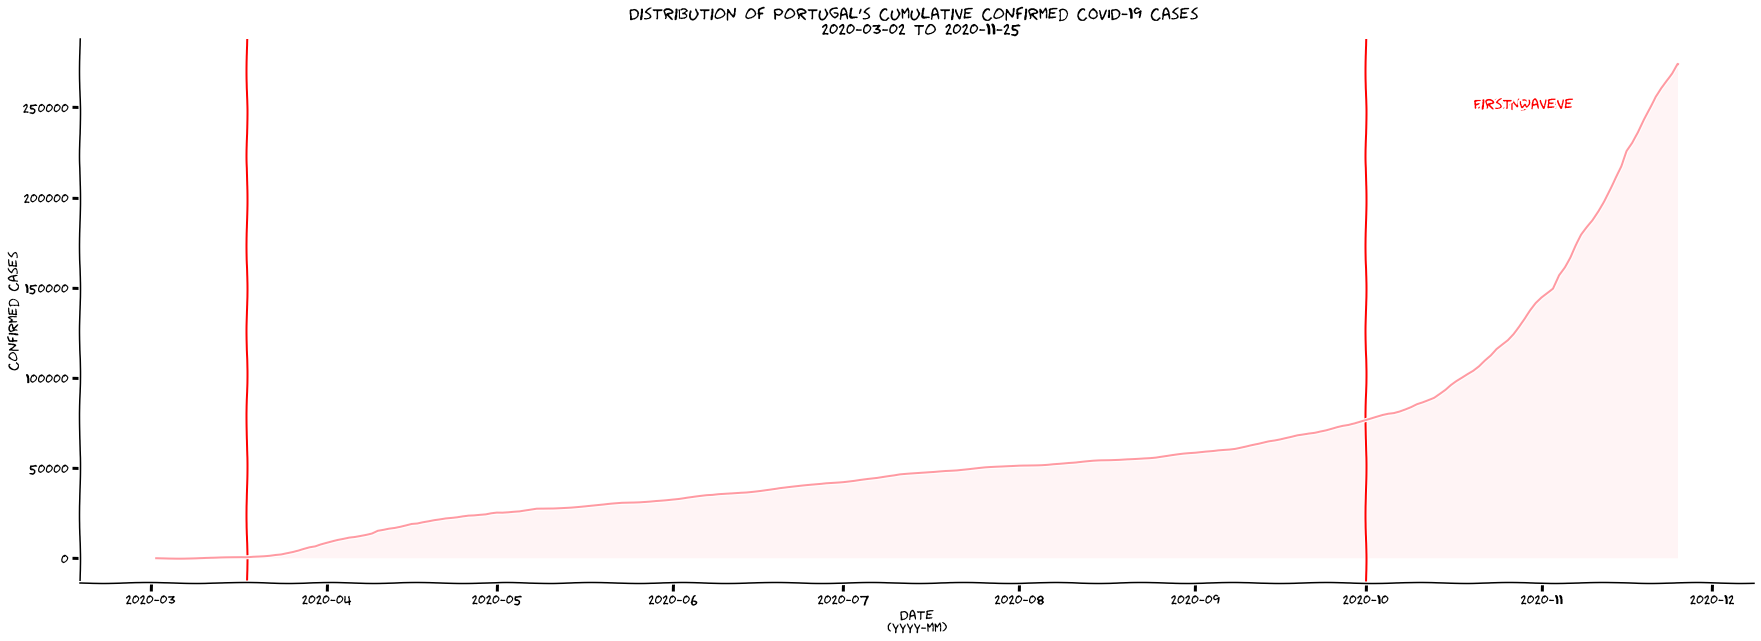

In [8]:
matplotlib.pyplot.xkcd(scale=0.5, length=100, randomness=2)
plt.figure(figsize=(30,10))


x = df.index
y = df['y']

ax = plt.subplot(111)
ax.plot(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Confirmed Cases')
ax.set_xlabel('Date\n(yyyy-mm)')
ax.set_title('Distribution of Portugal’s Cumulative Confirmed COVID-19 Cases \n 2020-03-02 to 2020-11-25')

ax.fill_between(x, y, facecolor='#FF9AA2', alpha=0.1)

x = datetime(2020, 10, 1)
x1 = datetime(2020, 3, 18)
plt.axvline(x = x, color = 'r')
plt.axvline(x = x1, color = 'r')

text1 = datetime(2020, 10, 20)
text2 = datetime(2020, 6, 20)
ax.text(text1, 250000, 'Second Wave', fontsize=15,  color='red')
ax.text(text1, 250000, 'First Wave', fontsize=15,  color='red')

plt.plot(df, color='#FF9AA2')


In [9]:
df.dtypes

y    int64
dtype: object

In [10]:
dataset = df.loc['2020-08-01':'2020-11-25']

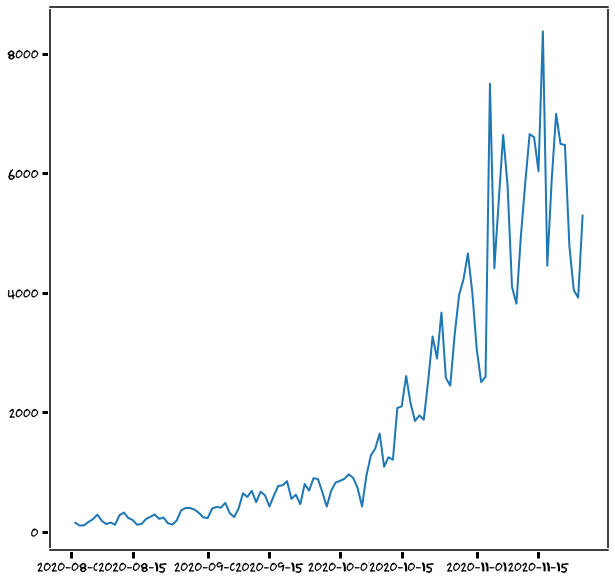

In [11]:
matplotlib.pyplot.xkcd(scale=0, length=100, randomness=2)
plt.figure(figsize=(10,10))
plt.plot(dataset.diff())
plt.savefig("Portugal's Cummulative Daily Cases")

In [12]:
dataset_diff = dataset.diff()
dataset_diff = dataset_diff.loc['2020-08-02' : '2020-11-25']
dataset = dataset.loc['2020-08-02' : '2020-11-25']

dataset = dataset_diff

2. Modeling

2.1. ARIMAX / SARIMAX

In [13]:
start_date = '2020-11-15'

train = dataset.loc[dataset.index < pd.to_datetime(start_date)]
test = dataset.loc[dataset.index >= pd.to_datetime(start_date)]

In [14]:
model = SARIMAX(train, order=(5,1,0))

In [15]:
results = model.fit(disp=True)

In [16]:
model_diff = pm.auto_arima(train,trace=True, error_action='ignore', start_p=0,start_q=0,max_p=5,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)

print(model_diff.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1662.244, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1655.415, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1653.535, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1652.928, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1649.756, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1641.881, Time=0.11 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0] intercept
Total fit time: 0.334 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(5, 1, 0)   Log Likelihood                -813.941
Date:                Sat, 05 Dec 2020   AIC                           1641.881
Time:                        21:33:27   BIC                           1660.392
Sample:                             0   HQIC                          1649.380
                                - 105                

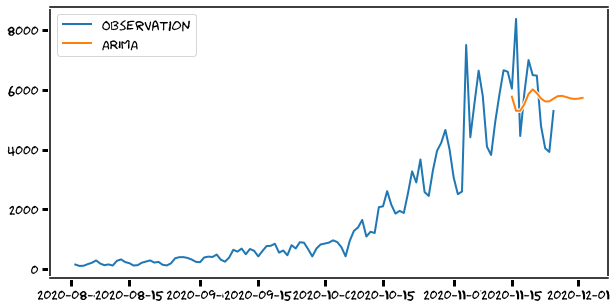

In [17]:
sarimax_prediction = results.predict(
    start='2020-11-15', end='2020-12-02', dynamic=False)
plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1,l2])

In [18]:
df_sarimax_prediction = pd.DataFrame(data=sarimax_prediction)
df_sarimax_prediction

,predicted_mean
2020-11-15,5767.204823
2020-11-16,5295.302467
2020-11-17,5295.870117
2020-11-18,5519.352879
2020-11-19,5857.381273
2020-11-20,6011.810576
2020-11-21,5884.091613
2020-11-22,5706.558399
2020-11-23,5608.632478
2020-11-24,5611.385463


2.2. Prophet

In [19]:
train['ds'] = train.index.values

In [20]:
m = Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
future = m.make_future_dataframe(periods=32)
prophet_prediction= m.predict(future)

In [22]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= '2020-11-15']

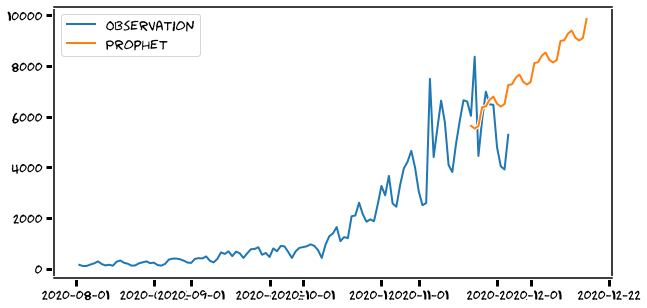

In [23]:
plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1,l2])

In [24]:
df_prophet_future = pd.DataFrame(data=prophet_future)
df_prophet_future

,yhat
ds,
2020-11-15,5642.099800
2020-11-16,5534.290093
2020-11-17,5632.584031
2020-11-18,6383.652010
2020-11-19,6412.620219
2020-11-20,6673.026825
2020-11-21,6795.935905
2020-11-22,6511.641582
2020-11-23,6403.831875


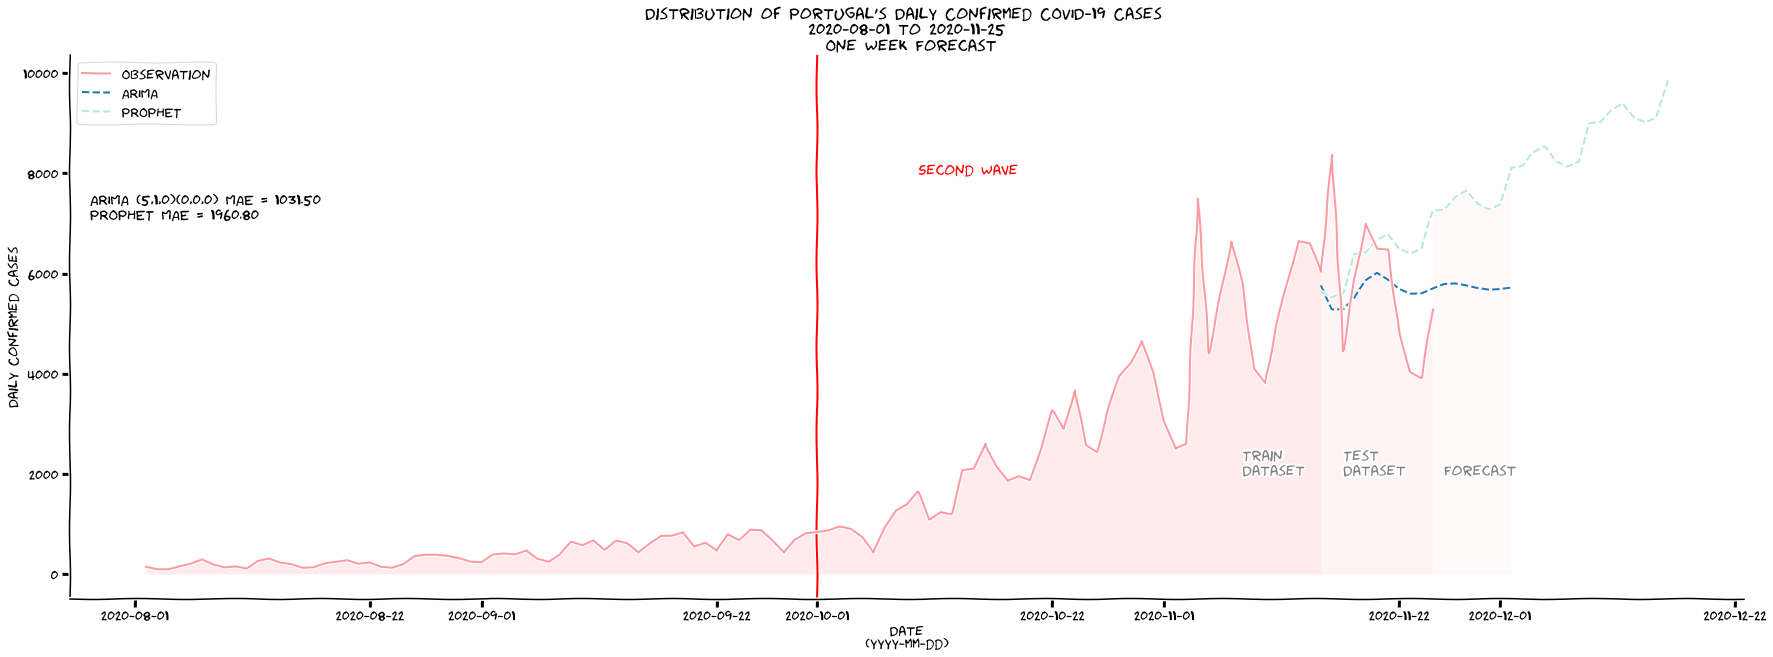

In [25]:
import time
from datetime import datetime
from datetime import date, timedelta as td
matplotlib.pyplot.xkcd(scale=0.5, length=100, randomness=2)
plt.figure(figsize=(30,10))


x = dataset.index
y1 = dataset['y']

l1, = plt.plot(dataset, label='Observation', color='#FF9AA2')
l2, = plt.plot(sarimax_prediction,'--', label='ARIMA')
l3, = plt.plot(prophet_future,'--', label='PROPHET',color='#B5EAD7')

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Daily Confirmed Cases')
ax.set_xlabel('Date\n(yyyy-mm-dd)')
ax.set_title('Distribution of Portugal’s Daily Confirmed COVID-19 Cases \n 2020-08-01 to 2020-11-25 \n One Week Forecast')

loc = dataset.loc['2020-08-02' : '2020-11-15']
ax.fill_between(loc.index, loc['y'], facecolor='#FF9AA2', alpha=0.2)
loc2 = dataset.loc['2020-11-15' : '2020-11-25']
ax.fill_between(loc2.index, loc2['y'], facecolor='#FF9AA2', alpha=0.1)
loc2 = df_prophet_future.loc['2020-11-25' : '2020-12-02']
ax.fill_between(loc2.index, loc2['yhat'], facecolor='#FF9AA2', alpha=0.05)

plt.axvline(x = datetime(2020, 10, 1), color = 'r')
text1 = datetime(2020, 10, 10)
ax.text(text1, 8000, 'Second Wave', fontsize=15,  color='red')


text1 = datetime(2020, 11, 8)
ax.text(text1, 2000, 'Train\nDataset', fontsize=15,  color='grey')


text1 = datetime(2020, 11, 17)
ax.text(text1, 2000, 'Test\nDataset', fontsize=15,  color='grey')

text1 = datetime(2020, 11, 26 )
ax.text(text1, 2000, 'Forecast', fontsize=15,  color='grey')

text1 = datetime(2020, 7, 28)
ax.text(text1, 7400, 'ARIMA (5,1,0)(0,0,0) MAE = 1031.50', fontsize=15,  color='black')
text1 = datetime(2020, 7, 28)
ax.text(text1, 7100, 'PROPHET MAE = 1960.80', fontsize=15,  color='black')

plt.legend(handles=[l1,l2,l3])
plt.plot(dataset, color='#FF9AA2')

2.3 XGBOOST

In [26]:
def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.y
    return X, y

featurize(dataset_diff)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,2,8,3,6,215,31
1,3,8,3,0,216,32
2,4,8,3,1,217,32
3,5,8,3,2,218,32
4,6,8,3,3,219,32


In [27]:
X_train, y_train = featurize(
    dataset.loc[dataset_diff.index < pd.to_datetime(start_date)])

X_test, y_test = featurize(
    dataset.loc[dataset_diff.index >= pd.to_datetime(start_date)])

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

In [30]:
XGBOOST_model = XGBRegressor(n_estimators=20)

In [31]:
XGBOOST_model.fit(scaled_train, y_train,
                  eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
                  verbose=True)
XGBOOST_prediction = XGBOOST_model.predict(scaled_test)

[21:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2137.27	validation_1-rmse:5349.32
[1]	validation_0-rmse:1950.58	validation_1-rmse:4896.79
[2]	validation_0-rmse:1781.92	validation_1-rmse:4488.48
[3]	validation_0-rmse:1629.73	validation_1-rmse:4120.53
[4]	validation_0-rmse:1491.72	validation_1-rmse:3834.37
[5]	validation_0-rmse:1364.85	validation_1-rmse:3590.2
[6]	validation_0-rmse:1251.44	validation_1-rmse:3357.22
[7]	validation_0-rmse:1148.96	validation_1-rmse:3148.24
[8]	validation_0-rmse:1056.17	validation_1-rmse:2925.21
[9]	validation_0-rmse:970.753	validation_1-rmse:2768.15
[10]	validation_0-rmse:894.719	validation_1-rmse:2618.82
[11]	validation_0-rmse:826.302	validation_1-rmse:2486.04
[12]	validation_0-rmse:763.859	validation_1-rmse:2376.41
[13]	validation_0-rmse:708.332	validation_1-rmse:2245.78
[14]	validation_0-rmse:657.986	validation_1-rmse:2160.96
[15]	validation_0-rmse:611.96

In [32]:
print('XGBOOST MAE =', mean_absolute_error(XGBOOST_prediction, y_test))

XGBOOST MAE = 1296.6774236505682


2.4. Neural Network

In [33]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(scaled_train.shape[1], )))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.5))
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=220, verbose=1)
NN_prediction = NN_model.predict(scaled_test)

Epoch 1/220
4/4 [==============================] - 0s 34ms/step - loss: 1514.0402 - val_loss: 5339.7490
Epoch 2/220
4/4 [==============================] - 0s 6ms/step - loss: 1053.3723 - val_loss: 1235.0751
Epoch 3/220
4/4 [==============================] - 0s 6ms/step - loss: 977.3257 - val_loss: 2142.8225
Epoch 4/220
4/4 [==============================] - 0s 6ms/step - loss: 784.6504 - val_loss: 2431.3176
Epoch 5/220
4/4 [==============================] - 0s 6ms/step - loss: 699.0717 - val_loss: 3056.5828
Epoch 6/220
4/4 [==============================] - 0s 5ms/step - loss: 701.5391 - val_loss: 2482.9880
Epoch 7/220
4/4 [==============================] - 0s 5ms/step - loss: 683.5798 - val_loss: 2847.8965
Epoch 8/220
4/4 [==============================] - 0s 6ms/step - loss: 653.5383 - val_loss: 2716.6516
Epoch 9/220
4/4 [==============================] - 0s 5ms/step - loss: 687.9376 - val_loss: 2530.6797
Epoch 10/220
4/4 [==============================] - 0s 5ms/step - loss: 633.055

In [34]:
print('NN MAE =', mean_absolute_error(NN_prediction, y_test))

NN MAE = 2530.92333984375


3. Overview

Text(0.5, 1.0, 'NN')

<Figure size 3600x3600 with 0 Axes>

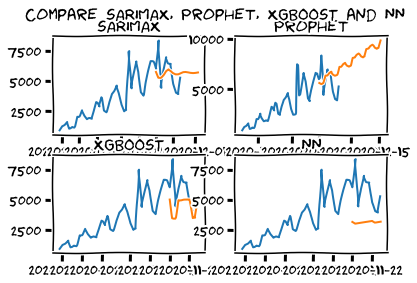

In [35]:
XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index

plt.figure(figsize=(50,50))
fig,axs = plt.subplots(2,2)
fig.suptitle('Compare SARIMAX, Prophet, XGBOOST and NN')
axs[0, 0].plot(dataset.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")
